In [2]:
import pandas as pd
import numpy as np
from IPython.display import display_html
from sklearn.model_selection import train_test_split
from sklearn.multiclass import OneVsRestClassifier
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from utils import Utils
from sklearn.ensemble import GradientBoostingClassifier
import time
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

In [3]:
ut = Utils()
X, Y = ut.get_matrixes()

In [4]:
#ejercicio de código
def entrenamiento_sin_seleccion_caracteristicas(num_trees, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    EficienciaTrain = []
    EficienciaVal = []
    f1 = [] 
    gmean =[]
    j = 0
    kf = StratifiedKFold(n_splits=4)
    for train, test in kf.split(X, Y):
        Xtrain, Ytrain, Xtest, Ytest = ut.get_training_test(X=X, Y=Y, train=train, test=test)
        
        #Creamos el clasificador SVM.
        clf = GradientBoostingClassifier(n_estimators=num_trees)
        clf.fit(Xtrain, Ytrain)
        f1_score_current, gmean_current, eficiencia_train_current, eficiencia_test_current = ut.get_metrics(model=clf, X_train=Xtrain, X_test=Xtest, y_train=Ytrain, Ytest=Ytest)
        tiempo_i = time.time()
        EficienciaTrain.append(eficiencia_train_current)
        EficienciaVal.append(eficiencia_test_current)
        gmean.append(gmean_current)           
        f1.append(f1_score_current)

    f1_ = np.mean(f1)
    f1_std = np.std(f1)
    gmean_ = np.mean(gmean)
    gmean_std = np.std(gmean)
    EficienciaVal_ = np.mean(EficienciaVal)
    EficienciaVal_std = np.std(EficienciaVal)
    EficienciaTrain_ = np.mean(EficienciaTrain)
    Eficienciatrain_std = np.std(EficienciaTrain)
    
    print("F1STD= " + str(f1_std))
    
    
    return clf, f1_, f1_std, gmean_, gmean_std, EficienciaVal_, EficienciaVal_std, EficienciaTrain_, Eficienciatrain_std

In [5]:
#ejercicio de código
def recursive_feature_elimination_wrapper(estimator, feature_numbers, X,Y):
    """
    Esta función es un envoltorio del objeto RFE de sklearn

    Parámetros:
    estimator(sklearn.svm.SVC), El estimador SVM
    feature_numbers(int), El número de características a considerar
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas

    Retorna:
    El modelo entrenado ()
    La máscara de características seleccionada, array [longitud de caracterisitcas de X]
    El rankeo de características, array [longitud de caracterisitcas de X]
    El objeto RFE entrenado sobre el set reducido de características
    El tiempo de ejecución
    """
    rfe = RFE(estimator=estimator, n_features_to_select=feature_numbers, step=1)
    tiempo_i = time.time()
    rfe.fit(X=X, y=Y)
    time_o = time.time()-tiempo_i
    feature_mask = rfe.support_
    features_rank = rfe.ranking_
    estimator = rfe.estimator_
    return rfe, feature_mask, features_rank, estimator, time_o

In [6]:
#ejercicio de código
def experimentar(n_feats, n_sets, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: CON_SEL, NUM_VAR, NUM_SPLITS, ERROR_VALIDACION, IC_STD_VALIDACION, 
    y T_EJECUCION. 

    """
    df = pd.DataFrame()
    idx = 0
    for split_number in n_sets:
        clf, f1_, f1_std, gmean_, gmean_std, EficienciaVal_, EficienciaVal_std, EficienciaTrain_, Eficienciatrain_std = entrenamiento_sin_seleccion_caracteristicas(split_number,X,Y)        
        df.loc[idx,'CON_SEL'] = 'NO'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'NUM_SPLITS'] = split_number
        df.loc[idx,'F1 Score'] = f1_
        df.loc[idx,'F1 Score IC'] = f1_std
        df.loc[idx,'Gmean'] = gmean_
        df.loc[idx,'Gmean IC'] = gmean_std
        df.loc[idx,'Eficiencia Test'] = EficienciaVal_
        df.loc[idx,'Eficiencia Test IC'] = EficienciaVal_std
        df.loc[idx,'Eficiencia Train'] = EficienciaTrain_
        df.loc[idx,'Eficiencia Train IC'] = Eficienciatrain_std
        idx+=1
    print("termina experimentos sin selección")
    #Con selección de características
    
    for f in n_feats:
        for split_number in n_sets:
            #Implemetamos la metodología de validación 
            EficienciaTrain = []
            EficienciaVal = []
            f1 = [] 
            gmean =[]
            times = np.ones(split_number)
            kf = StratifiedKFold(n_splits=split_number)
            j = 0
            for train_index, test_index in kf.split(X, Y):
                
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = Y[train_index], Y[test_index]
                
                clf =  GradientBoostingClassifier(n_estimators=50)
                
                # se ignorar las otras salidas
                
                rfe, _, _, _, t = recursive_feature_elimination_wrapper(estimator=clf,feature_numbers=f, X=X_train,Y=y_train)
                                
                
                f1_score_current, gmean_current, eficiencia_train_current, eficiencia_test_current = ut.get_metrics(model=rfe, X_train=X_train, X_test=X_test, y_train=y_train, Ytest=y_test)
                EficienciaTrain.append(eficiencia_train_current)
                EficienciaVal.append(eficiencia_test_current)
                f1.append(f1_score_current)
                gmean.append(gmean_current)
                times[j] = t
                j+=1

            df.loc[idx,'CON_SEL'] = 'SI'
            df.loc[idx,'NUM_VAR'] = f
            df.loc[idx,'NUM_SPLITS'] = split_number
            df.loc[idx,'F1 Score'] = np.mean(f1)
            df.loc[idx, 'F1 Score IC'] = np.std(f1)
            df.loc[idx, 'Gmean'] = np.mean(gmean)
            df.loc[idx, 'Gmean IC'] = np.std(gmean)
            df.loc[idx, 'Eficiencia Test'] = np.mean(EficienciaVal)
            df.loc[idx, 'Eficiencia Test IC'] = np.std(EficienciaVal)
            df.loc[idx, 'Eficiencia Train'] = np.mean(EficienciaTrain)
            df.loc[idx, 'Eficiencia Train IC'] = np.std(EficienciaTrain)
            idx+=1
    return df


In [6]:
dfr = experimentar(n_feats = [3, 5, 10,15,20], n_sets = [5, 10], X= X, Y=Y)

F1STD= 0.039788385041631354
F1STD= 0.04235882045100523
termina experimentos sin selección
[2. 1. 1. 1. 1. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 3. 3.
 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 3. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 1. 1. 1. 1.
 2. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 3. 2. 2. 2. 2. 1. 1. 2. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2.
 1. 2. 2. 2. 1. 2. 2. 2. 3. 3. 3. 

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 1. 2. 1. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 1. 2.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2.
 1. 2. 2. 1. 1. 2. 2. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1.
 1. 1. 1. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 3. 1.
 3. 3. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 1.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 3. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2.
 2. 2. 2. 2. 2. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 2. 1.

[2. 1. 1. 1. 1. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 3. 3.
 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 1.
 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3.
 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 3. 2. 3. 2.
 2. 2. 3. 3. 1. 2. 2. 3. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 3. 3. 3. 3. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 3. 1. 2. 2.
 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2.

[3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2.
 3. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2.
 2. 2. 3. 2. 2. 2. 2. 2. 2. 1. 2. 2. 3. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 2. 2. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 2. 3. 3. 2. 2. 2. 2. 3. 2. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 2. 1. 1. 1.
 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 3. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 2. 3. 3. 3. 2. 2. 2.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

[2. 1. 1. 1. 1. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 3. 3.
 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 3. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2. 1.
 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1.
 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 2. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 3. 2. 2. 2. 2. 1. 1. 1. 1. 2. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2.
 2. 2. 2. 2. 2. 3. 2. 3. 3. 2. 2. 3. 3. 1. 2. 2. 3.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1.
 1. 1. 1. 3. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 1. 2. 2. 2. 2. 2. 2.
 2. 2. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 3. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1.

[2. 1. 1. 1. 1. 3. 3. 3. 3. 3. 2. 2. 1. 1. 1. 1. 1. 2. 1. 1. 3. 1. 3. 3.
 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 2. 3. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 2. 2. 1. 1. 2. 2. 1.
 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 2. 2. 3. 3. 3. 2.
 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1.
 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 1.
 1. 1. 2. 1. 1. 1. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 2. 2. 1. 1. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 3.
 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 3. 2. 3. 3.
 2. 1. 3. 3. 1. 2. 2. 3. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 3. 3. 3. 3. 2. 2.
 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2. 3. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 2. 2.

[3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 2. 1. 1. 1. 2. 1. 1. 1. 1. 1. 2. 2. 2. 2. 2. 2. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 1. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.

In [7]:
dfr

,CON_SEL,NUM_VAR,NUM_SPLITS,F1 Score,F1 Score IC,Gmean,Gmean IC,Eficiencia Test,Eficiencia Test IC,Eficiencia Train,Eficiencia Train IC
0,NO,22.0,5.0,0.880000,0.039788,0.910633,0.027727,0.881569,0.036516,0.922525,0.010486
1,NO,22.0,10.0,0.897438,0.042359,0.924065,0.029244,0.899294,0.038573,0.935818,0.008242
2,SI,3.0,5.0,0.880326,0.027231,0.910516,0.019732,0.881370,0.026008,0.918731,0.023995
3,SI,3.0,10.0,0.877356,0.060704,0.909219,0.042020,0.879767,0.055267,0.920017,0.017467
4,SI,5.0,5.0,0.926485,0.038325,0.945701,0.026987,0.927895,0.035682,0.957351,0.005948
5,SI,5.0,10.0,0.932697,0.045602,0.950564,0.031206,0.934333,0.041254,0.955265,0.003746
6,SI,10.0,5.0,0.924918,0.048418,0.944913,0.033847,0.926888,0.044741,0.969235,0.005914
7,SI,10.0,10.0,0.931354,0.061714,0.950516,0.040245,0.934330,0.053095,0.967842,0.005503
8,SI,15.0,5.0,0.930311,0.049039,0.949016,0.034226,0.932326,0.045254,0.972709,0.006314
9,SI,15.0,10.0,0.931534,0.066028,0.950803,0.043107,0.934732,0.056844,0.971422,0.003247


In [7]:
X_train, X_test, y_train, y_test = ut.get_train_test()

In [8]:
clf =  GradientBoostingClassifier(n_estimators=50)

In [9]:
rfe, feature_mask, features_rank, estimator, time_o = recursive_feature_elimination_wrapper(estimator=clf,feature_numbers=15, X=X_train,Y=y_train)

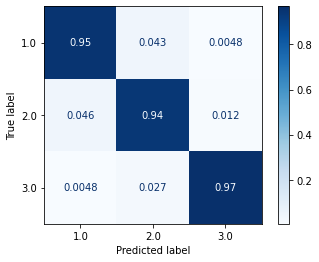

In [22]:
plot_confusion_matrix(rfe,X=X_test, y_true=y_test,normalize='true', cmap=plt.cm.Blues)

In [10]:
feature_mask

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
       False, False,  True, False, False,  True,  True,  True, False,
       False,  True,  True,  True])

In [11]:
features_rank

array([1, 1, 1, 1, 1, 1, 1, 1, 4, 6, 8, 1, 7, 3, 1, 1, 1, 5, 2, 1, 1, 1])